# Lab 7.7 - Random Forests and Boosted Regression

## Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

import sklearn.linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import LinearRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

In [4]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2 
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [5]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [6]:
numerical = pd.read_csv('numerical.csv')
categorical = pd.read_csv('categorical.csv')
targets = pd.read_csv('target.csv')

In [7]:
data = pd.concat([numerical, categorical, targets], axis = 1)

In [8]:
data.shape

(95412, 339)

In [9]:
y = data['TARGET_B']
X = data.drop(['TARGET_B'], axis = 1)

numericalX = X.select_dtypes(np.number)
categoricalX = X.select_dtypes(object)

encoder = OneHotEncoder(drop='first').fit(categoricalX)
encoded_categorical = encoder.transform(categoricalX).toarray()
encoded_categorical = pd.DataFrame(encoded_categorical)
X = pd.concat([numericalX, encoded_categorical], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
# Oversampling our target

trainset = pd.concat([X_train, y_train], axis=1)

print(trainset['TARGET_B'].value_counts())

category_0 = trainset[trainset['TARGET_B']== 0 ]
category_1_upsampled = resample(trainset[trainset['TARGET_B']==1], 
                                  replace=True, 
                                  n_samples = len(category_0))

print(category_1_upsampled.shape)

train_oversampled = pd.concat([category_0, category_1_upsampled], axis=0)
train_oversampled = train_oversampled.sample(frac =1)

y_train = train_oversampled['TARGET_B'].copy()
X_train = train_oversampled.drop('TARGET_B', axis=1).copy()

print(X_train.shape)

0    72486
1     3843
Name: TARGET_B, dtype: int64
(72486, 356)
(144972, 355)


In [11]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

y_train_regression = X_train['TARGET_D']
y_test_regression = X_test['TARGET_D']

X_train = X_train.drop(['TARGET_D'], axis = 1)
X_test = X_test.drop(['TARGET_D'], axis = 1)

In [12]:
clf = RandomForestClassifier(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf =20, 
                             max_samples=0.2,
                             random_state = 69)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

y_pred = clf.predict(X_test)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred))

0.6206301906575062
0.6104386102814023


0    18083
1     1000
Name: TARGET_B, dtype: int64

array([[11106,  6977],
       [  457,   543]])

In [ ]:
# Checking with cross validation (this is too cpu intensive for my macbook :( ... )

clf = RandomForestClassifier(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf =20)
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(np.mean(cross_val_scores))

## Applying feature selection techniques

### K-Best

In [15]:
scaler = MinMaxScaler()

numerical_scaled = scaler.fit_transform(numerical)

In [16]:
X = numerical_scaled
y = targets['TARGET_B']

kbest = SelectKBest(chi2, k=10).fit_transform(X, y)

selected = pd.DataFrame(kbest)
selected.head()

,0,1,2,3,4,5,6,7,8,9
0,0.010101,0.020202,0.070707,0.131313,0.272727,0.000000,0.020202,0.050505,0.341463,1.000000
1,0.000000,0.979798,0.989899,0.989899,0.989899,0.949495,0.919192,0.919192,0.024390,0.333333
2,0.020202,0.000000,0.010101,0.060606,0.181818,0.000000,0.000000,0.020202,0.341463,1.000000
3,0.000000,0.101010,0.252525,0.505051,0.696970,0.101010,0.010101,0.080808,0.170732,1.000000
4,0.989899,0.000000,0.010101,0.020202,0.161616,0.000000,0.252525,0.585859,0.195122,0.333333


In [17]:
model = SelectKBest(chi2, k=10).fit(X, y)
df = pd.DataFrame(data = model.scores_, columns = ['score'])
df['column'] = numerical.columns
print(df.sort_values(by = ['score'], ascending = False).head(10))

          score    column
313  210.290810    RFA_2F
305   27.516508  CARDGIFT
110   26.474583      HVP1
111   25.757492      HVP2
112   21.545080      HVP3
115   19.261394      HVP6
113   14.874056      HVP4
22    13.034181      ETH2
129   12.581538       RP1
130   11.022637       RP2


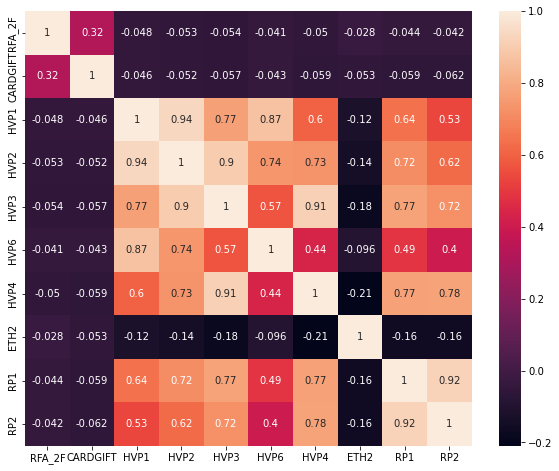

In [18]:
# After visualizing it, still some multicollinearity...

corr_matrix=numerical[['RFA_2F',
 'CARDGIFT',
 'HVP1',
 'HVP2',
 'HVP3',
 'HVP6',
 'HVP4',
 'ETH2',
 'RP1',
 'RP2']].corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

### RFE (could not get this to work)

In [ ]:
# X = numerical_scaled
# y = targets['TARGET_B']

# LR = linear_model.LogisticRegression()

# rfe = RFE(LR, n_features_to_select=20, verbose=False)
# rfe.fit(X, y)

In [ ]:
# df = pd.DataFrame(data = rfe.ranking_, columns=['Rank'])
# df['Column_name'] = pd.DataFrame(numerical).columns
# df[df['Rank']==1]

### PCA (could not get this to work)

In [ ]:
# from sklearn.decomposition import PCA

In [ ]:
# pca = PCA(0.85)
# pca.fit(numerical_scaled)

In [ ]:
# X_train_pca = pca.transform(X_train_norm)
# X_test_pca = pca.transform(X_test_norm)

In [ ]:
# pd.DataFrame(X_test_pca)

### Decision Tree Classifier

In [19]:
from sklearn.feature_selection import SelectFromModel

In [20]:
clf_2 = DecisionTreeClassifier(max_depth=4)
clf_2.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [ ]:
print("test data accuracy was ",clf_2.score(X_test,y_test))

print("train data accuracy was ",clf_2.score(X_train,y_train))

test data accuracy was  0.5909448199968559
train data accuracy was  0.5876790000827746


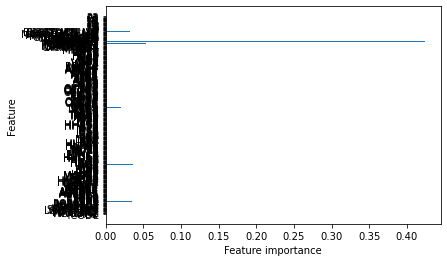

In [21]:
# Illegible chart so I used the get_best_features function later

def plot_feature_importances_hcfa(model):
    n_features = X_train.shape[1]
    plt.barh(range(n_features), clf_2.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances_hcfa(clf_2)

In [22]:
# Since we can't read the chart...
# Here is the list of most important features according to the decision tree classifier when n = 4

list(zip(X_train.columns, clf_2.feature_importances_))

[col[0] for col in zip(X_train.columns, clf_2.feature_importances_) if col[1] > 0]

['ETH2',
 'HU2',
 'DMA',
 'IC8',
 'IC15',
 'IC20',
 'LFC10',
 'NUMPRM12',
 'NGIFTALL',
 'CARDGIFT',
 'LASTGIFT',
 'RFA_2F',
 'LASTDATE_YR',
 'FIRSTDATE_MM']

In [76]:
# Out of curiousity, I found in the sklearn docs this 'SelectFromModel' which pulls out the same 14 columns!

model = SelectFromModel(clf_2, prefit=True)

X_keep = model.transform(X_train)

X_keep.shape

(144972, 14)

### Variance threshold

In [24]:
from sklearn.feature_selection import VarianceThreshold

In [25]:
var_threshold = 0.02
sel = VarianceThreshold(threshold=(var_threshold))

In [26]:
sel = sel.fit(numerical_scaled)
temp = sel.transform(numerical_scaled)
temp = pd.DataFrame(temp)

In [27]:
pd.DataFrame(temp).head()

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
0,0.608247,0.666667,1.000000,0.343434,0.181818,0.555556,0.0,0.353535,0.656566,0.929293,...,0.333333,0.656566,0.404040,0.285714,0.4,0.433333,0.498045,0.0,1.000000,0.622951
1,0.463918,0.833333,1.000000,0.555556,0.111111,1.000000,1.0,0.000000,0.000000,0.676768,...,1.000000,0.000000,1.000000,0.952381,0.8,0.183333,0.774510,0.0,0.333333,0.000000
2,0.624862,0.333333,0.111111,0.292929,0.333333,0.111111,0.0,0.020202,0.989899,0.969697,...,0.222222,0.777778,0.171717,0.428571,0.4,0.416667,0.078617,1.0,1.000000,0.967213
3,0.711340,0.000000,0.444444,0.141414,0.313131,0.000000,0.0,0.080808,0.929293,0.616162,...,0.232323,0.777778,0.222222,0.761905,0.4,0.433333,0.899764,1.0,1.000000,0.655738
4,0.793814,0.333333,0.222222,0.090909,0.535354,1.000000,1.0,0.000000,0.000000,0.020202,...,1.000000,0.010101,0.212121,0.285714,0.4,0.700000,0.037079,1.0,0.333333,0.409836


In [28]:
sel.variances_ > var_threshold
sel.get_support()
var_list = list(sel.get_support())

In [ ]:
list(zip(numerical.columns, var_list))

In [69]:
drop_list = [col[0] for col in zip(numerical.columns, var_list) if col[1] == False]

len(drop_list)

236

### Choosing features to keep

In [ ]:
# Checkpoint - csv with final dataset to begin regression / classification 

In [40]:
# Using the variables identified in the Decision Tree Classifier

data_final = data[['ETH2',
 'HU2',
 'DMA',
 'IC8',
 'IC15',
 'IC20',
 'LFC10',
 'NUMPRM12',
 'NGIFTALL',
 'CARDGIFT',
 'LASTGIFT',
 'RFA_2F',
 'LASTDATE_YR',
 'FIRSTDATE_MM',
 'TARGET_D']]

In [41]:
data_final.to_csv('data_final.csv', index=False)

## Lab 2 - Regression models for Target D

In [ ]:
# Setting up regression for TARGET_D

In [ ]:
data_final = pd.read_csv('data_final.csv')

In [ ]:
# y_train_regression = X_train['TARGET_D']
# y_test_regression = X_test['TARGET_D']

In [80]:
data_final = data_final[data['TARGET_B']==1]

In [81]:
data_target_d = data_final['TARGET_D']

In [83]:
data_target_d

20        4.0
30        7.0
45        5.0
78       13.0
93       10.0
         ... 
95298    20.0
95309    15.0
95398     3.0
95403    10.0
95410    18.0
Name: TARGET_D, Length: 4843, dtype: float64

In [96]:
X_train_reg = X_train[['ETH2',
 'HU2',
 'DMA',
 'IC8',
 'IC15',
 'IC20',
 'LFC10',
 'NUMPRM12',
 'NGIFTALL',
 'CARDGIFT',
 'LASTGIFT',
 'RFA_2F',
 'LASTDATE_YR',
 'FIRSTDATE_MM']]

In [98]:
X_train_reg = data_final[data['TARGET_B']==1]

In [99]:
X_train_reg

,ETH2,HU2,DMA,IC8,IC15,IC20,LFC10,NUMPRM12,NGIFTALL,CARDGIFT,LASTGIFT,RFA_2F,LASTDATE_YR,FIRSTDATE_MM,TARGET_D
20,1,12,613.0,19,4,14,1,12,15,10,5.0,3,96,1,4.0
30,2,3,618.0,1,3,19,0,2,11,6,7.0,3,95,4,7.0
45,0,4,637.0,19,1,22,0,13,21,14,5.0,3,96,4,5.0
78,0,37,803.0,8,4,17,3,13,12,5,10.0,2,95,1,13.0
93,93,11,524.0,13,4,12,18,14,10,8,12.0,3,95,9,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95298,1,43,803.0,13,26,0,20,13,30,16,17.0,1,96,8,20.0
95309,1,28,862.0,16,5,7,1,10,3,2,15.0,1,95,10,15.0
95398,12,25,617.0,16,2,15,3,16,10,4,20.0,3,96,11,3.0
95403,0,21,613.0,17,14,5,3,8,12,6,20.0,1,96,3,10.0


In [88]:
X_test_reg = X_test[['ETH2',
 'HU2',
 'DMA',
 'IC8',
 'IC15',
 'IC20',
 'LFC10',
 'NUMPRM12',
 'NGIFTALL',
 'CARDGIFT',
 'LASTGIFT',
 'RFA_2F',
 'LASTDATE_YR',
 'FIRSTDATE_MM']]

In [100]:
X_test_reg = data_final[data['TARGET_B']==1]

In [103]:
# Decision Tree Regressor

regr = DecisionTreeRegressor(max_depth=2)

regr.fit(X_train_reg, data_target_d)

DecisionTreeRegressor(max_depth=2)

In [104]:
# Much better score compared to when we did not optimize for feature selection on TARGET_B

print("decision tree test data score was: ",regr.score(X_test_reg, data_target_d))
print("decision tree train data score was: ",regr.score(X_train_reg, data_target_d))

decision tree test data score was:  0.8477358638716953
decision tree train data score was:  0.8477358638716953


In [107]:
donation_gained = 811 * 0.79
donation_lost = 10808 * 0.79
unexpected_donation = 613 * 0.79
spend_marketing = (10808+811) * 0.79
no_return_marketing = 10808 * 0.79

print('Donation amount gained:',round(donation_gained,2))
print('Donation amount lost:',round(donation_lost,2))
print('Unexpected Donations:',round(unexpected_donation,2))
print('Amount spend on marketing:',round(spend_marketing,2))
print('Amount lost on marketing:',round(no_return_marketing,2))

Donation amount gained: 640.69
Donation amount lost: 8538.32
Unexpected Donations: 484.27
Amount spend on marketing: 9179.01
Amount lost on marketing: 8538.32
